TensorFlow version: 2.18.1
GPU Available: []
✅ Data path found: C:\Users\anask\crop-disease-detection\data\raw\plantvillage-dataset\plantvillage dataset\color
📁 Found 38 class folders
✅ Loaded 5 sample images
Analyzing 100 images...
✅ Saved: results/image_size_analysis.png


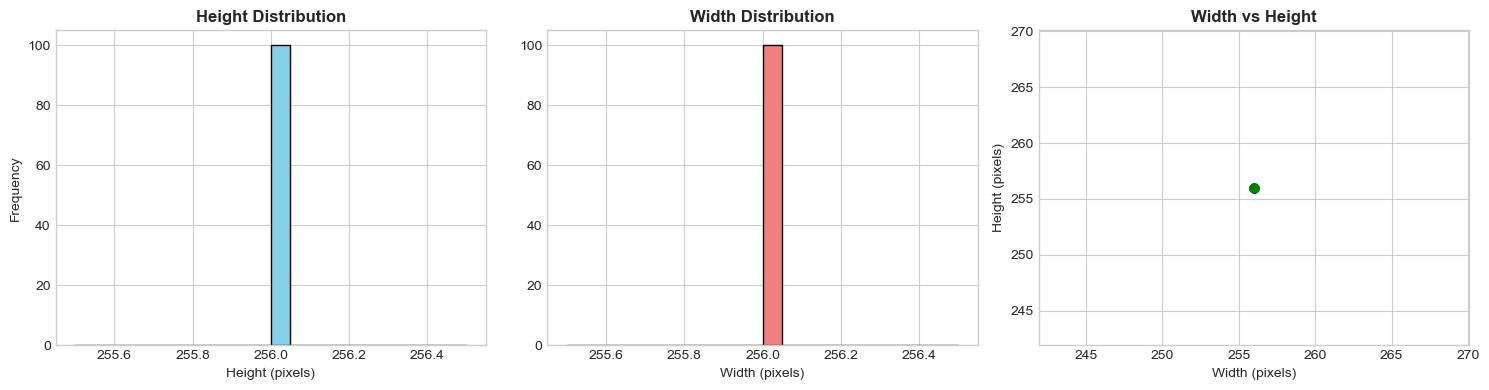


Image Size Statistics:
       height  width  aspect_ratio
count   100.0  100.0         100.0
mean    256.0  256.0           1.0
std       0.0    0.0           0.0
min     256.0  256.0           1.0
25%     256.0  256.0           1.0
50%     256.0  256.0           1.0
75%     256.0  256.0           1.0
max     256.0  256.0           1.0
✅ Saved: results/preprocessing_comparison.png


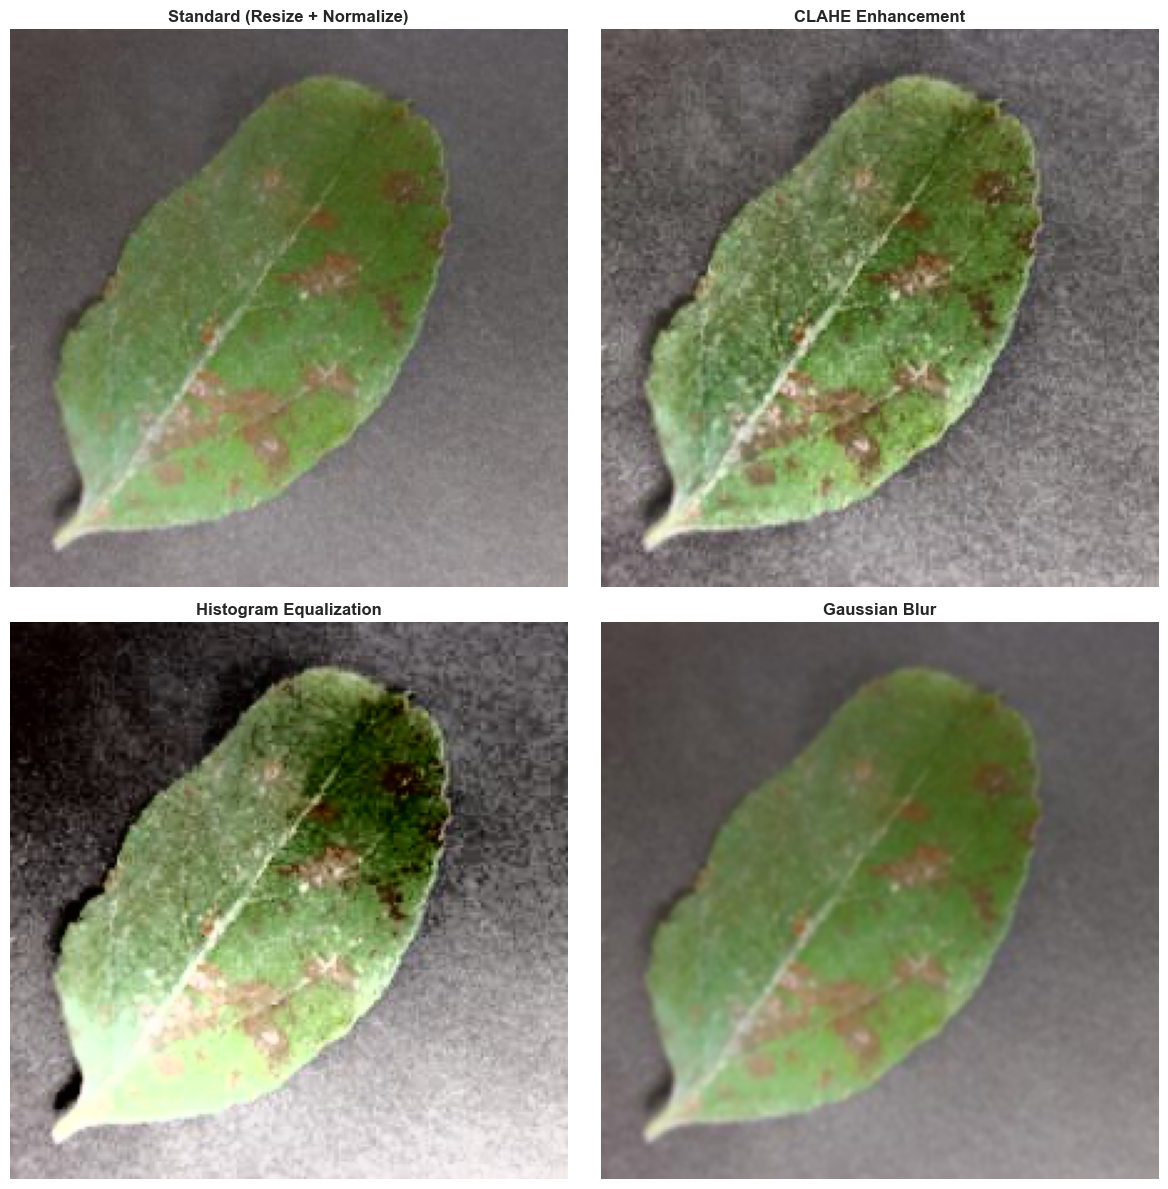

✅ Saved: results/augmentation_examples.png


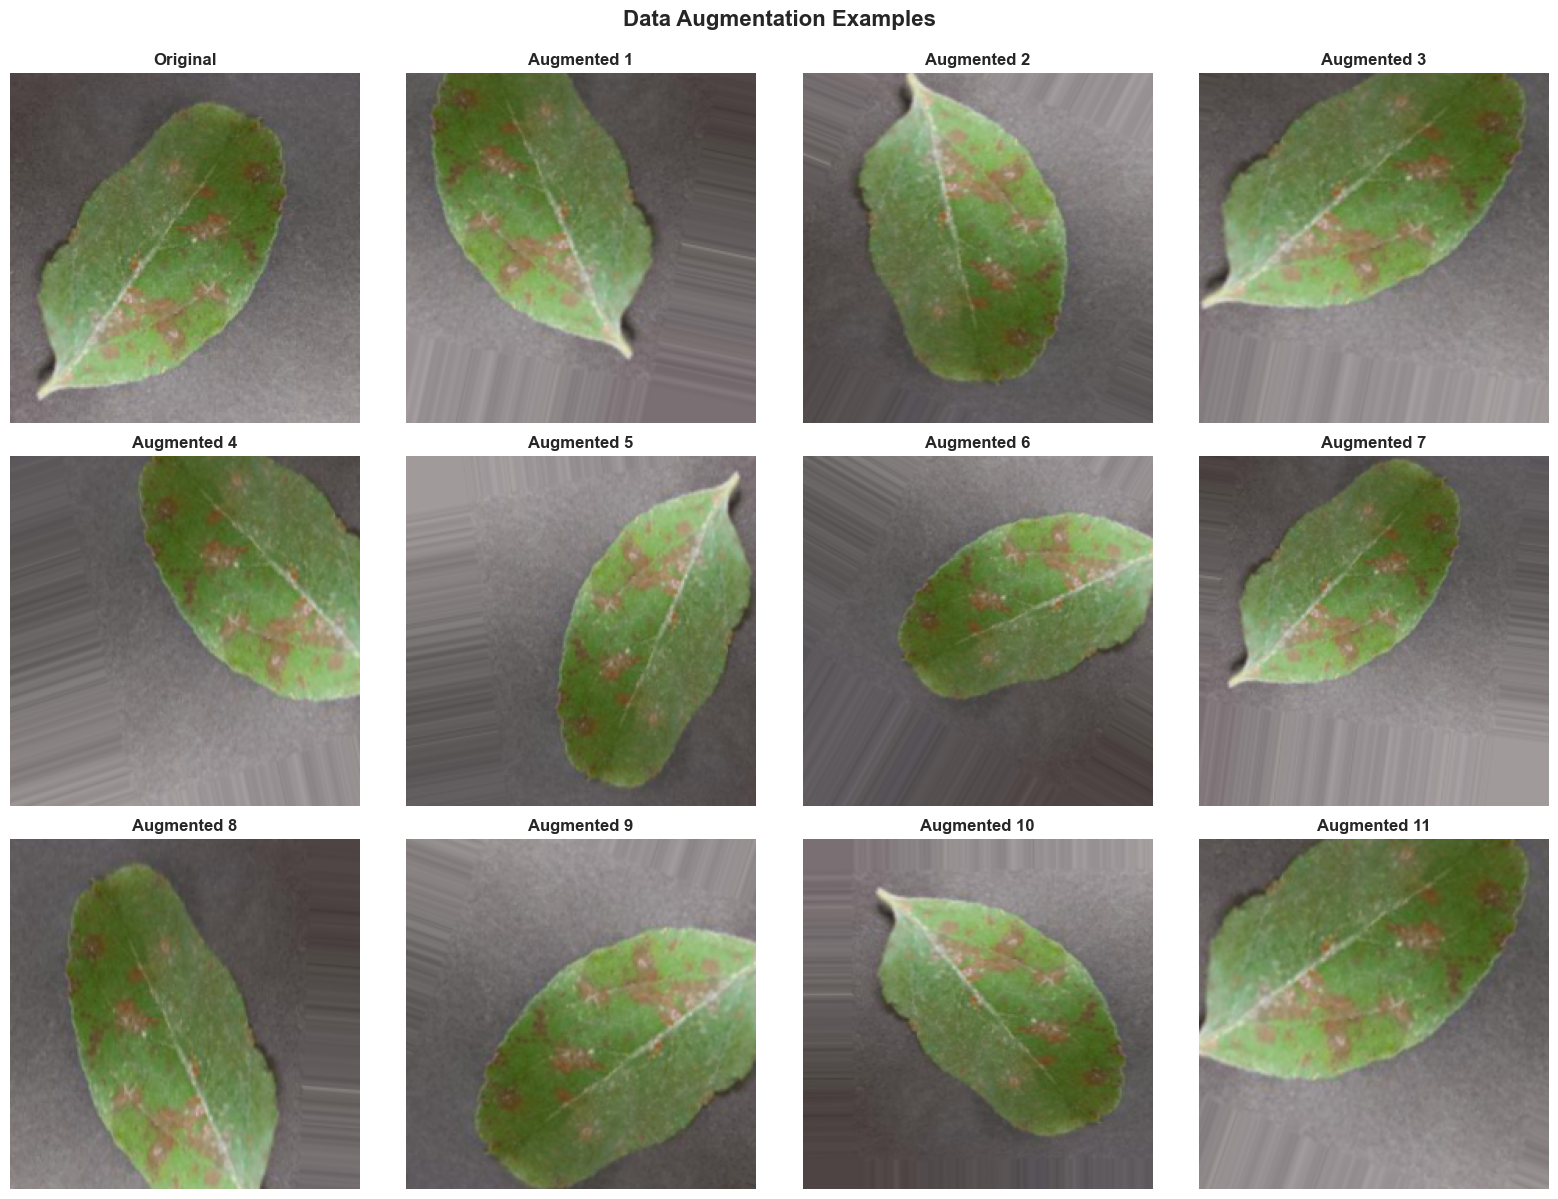

✅ Saved: results/augmentation_strength_comparison.png


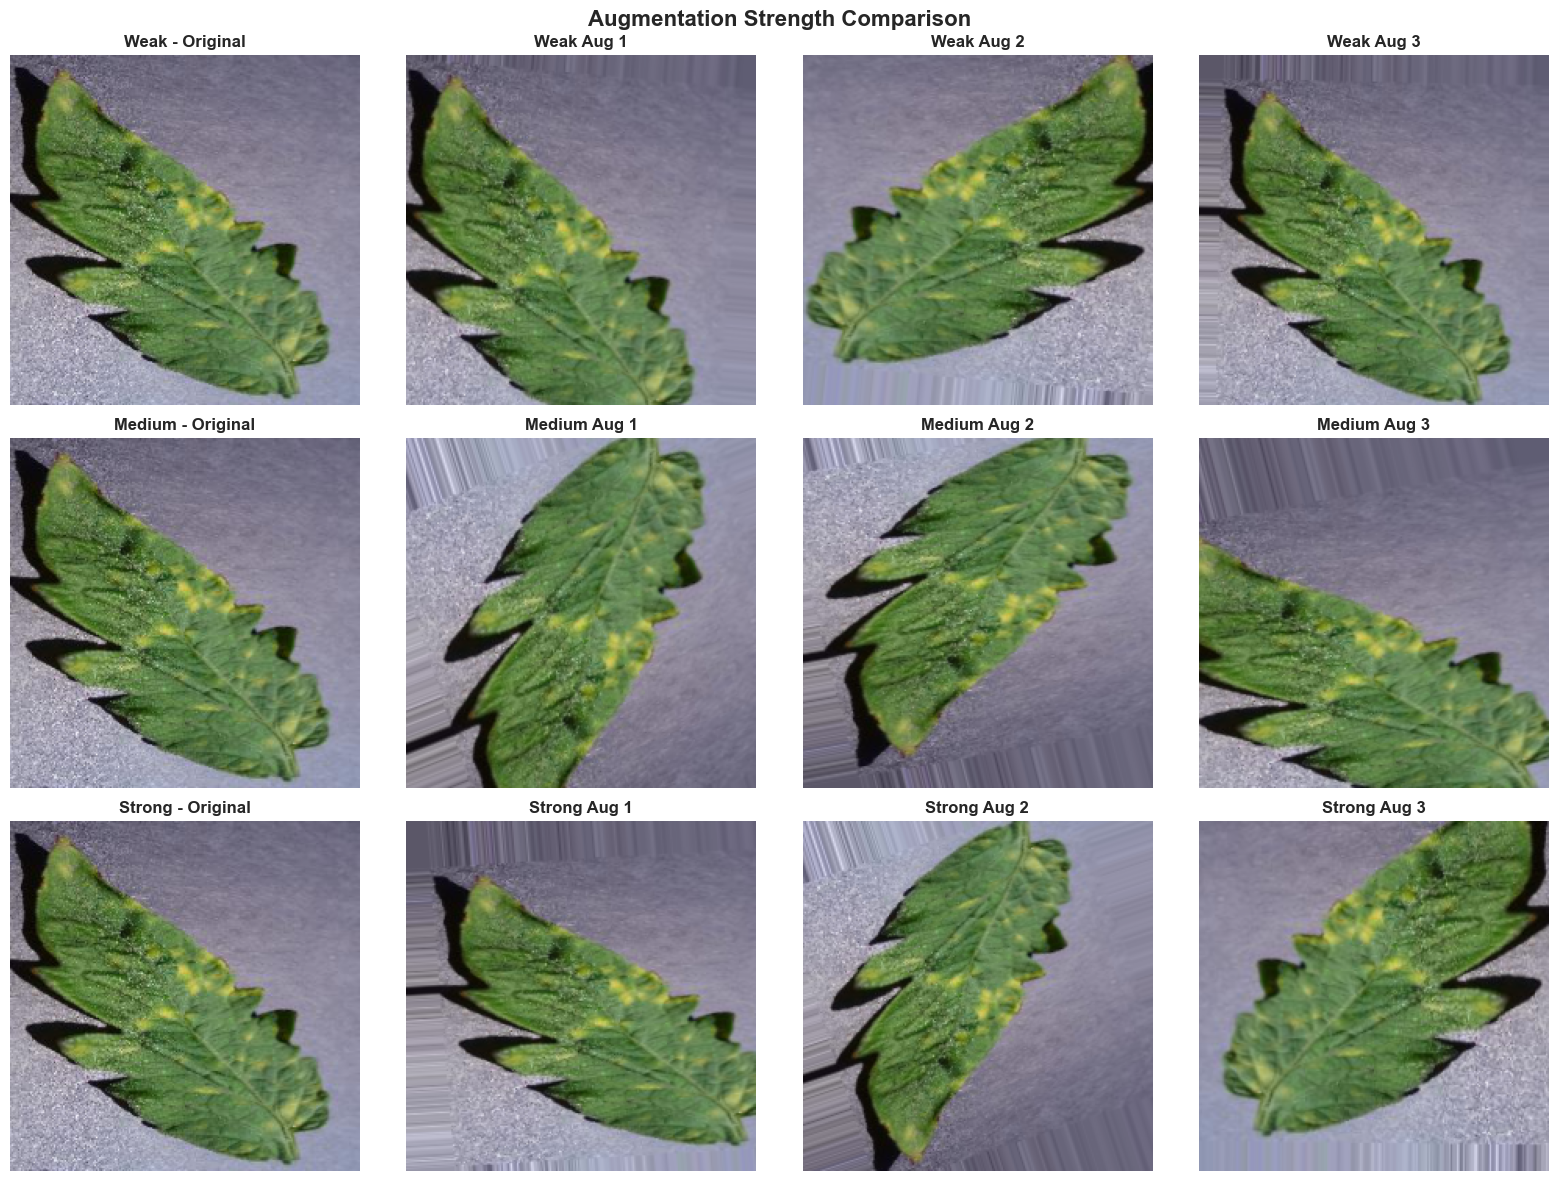

In [5]:
# %% [markdown]
# # 02 - Data Preprocessing & Augmentation Experiments
# This notebook tests different preprocessing strategies and augmentation techniques

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# %%
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# %% [markdown]
# ## 1. Load Sample Images

# %%
# CORRECTED PATH - Point to the 'color' folder
DATA_PATH = Path(r'C:\Users\anask\crop-disease-detection\data\raw\plantvillage-dataset\plantvillage dataset\color')
PROCESSED_PATH = Path(r'C:\Users\anask\crop-disease-detection\data\processed')

# Verify the path exists
if not DATA_PATH.exists():
    print(f"⚠️  Path not found: {DATA_PATH}")
    print("Available paths:")
    base_path = Path('data/raw/plantvillage-dataset')
    for item in base_path.rglob('*'):
        if item.is_dir() and 'color' in item.name.lower():
            print(f"  Found: {item}")
else:
    print(f"✅ Data path found: {DATA_PATH}")

# Get random sample from different classes
class_dirs = [d for d in DATA_PATH.iterdir() if d.is_dir()]
print(f"📁 Found {len(class_dirs)} class folders")

sample_classes = np.random.choice(class_dirs, min(5, len(class_dirs)), replace=False)
sample_images = []

for class_dir in sample_classes:
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
        if images:
            sample_images.append(np.random.choice(images))

print(f"✅ Loaded {len(sample_images)} sample images")

# %% [markdown]
# ## 2. Image Size Analysis

# %%
def analyze_image_sizes(image_paths):
    """Analyze dimensions of images"""
    sizes = []
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w, c = img.shape
            sizes.append({'height': h, 'width': w, 'aspect_ratio': w/h})
    return pd.DataFrame(sizes)

# Analyze 100 random images from multiple classes
all_images = []
for class_dir in list(class_dirs)[:10]:
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
        all_images.extend(images[:10])

print(f"Analyzing {len(all_images)} images...")
df_sizes = analyze_image_sizes(all_images)

# %%
Path('results').mkdir(exist_ok=True)

# Visualize size distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_sizes['height'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Height Distribution', fontweight='bold')
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_sizes['width'], bins=20, color='lightcoral', edgecolor='black')
axes[1].set_title('Width Distribution', fontweight='bold')
axes[1].set_xlabel('Width (pixels)')

axes[2].scatter(df_sizes['width'], df_sizes['height'], alpha=0.5, color='green')
axes[2].set_title('Width vs Height', fontweight='bold')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')

plt.tight_layout()
plt.savefig('results/image_size_analysis.png', dpi=150)
print("✅ Saved: results/image_size_analysis.png")
plt.show()

print(f"\nImage Size Statistics:")
print(df_sizes.describe())

# %% [markdown]
# ## 3. Test Different Preprocessing Techniques

# %%
def load_and_preprocess(image_path, method='standard'):
    """Load and preprocess image with different methods"""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"⚠️  Could not load image: {image_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if method == 'standard':
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
    
    elif method == 'clahe':
        img = cv2.resize(img, (224, 224))
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        img = cv2.merge([l, a, b])
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        img = img / 255.0
    
    elif method == 'histogram_eq':
        img = cv2.resize(img, (224, 224))
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        img = img / 255.0
    
    elif method == 'gaussian_blur':
        img = cv2.resize(img, (224, 224))
        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = img / 255.0
    
    return img

# %%
# Compare preprocessing methods
if len(sample_images) > 0:
    sample_img = sample_images[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    methods = ['standard', 'clahe', 'histogram_eq', 'gaussian_blur']
    titles = ['Standard (Resize + Normalize)', 'CLAHE Enhancement', 
              'Histogram Equalization', 'Gaussian Blur']
    
    for idx, (method, title) in enumerate(zip(methods, titles)):
        img = load_and_preprocess(sample_img, method=method)
        if img is not None:
            ax = axes[idx // 2, idx % 2]
            ax.imshow(img)
            ax.set_title(title, fontweight='bold', fontsize=12)
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/preprocessing_comparison.png', dpi=150)
    print("✅ Saved: results/preprocessing_comparison.png")
    plt.show()
else:
    print("⚠️  No sample images available for preprocessing comparison")

# %% [markdown]
# ## 4. Data Augmentation Testing

# %%
# Create augmentation generator (NO brightness range to avoid black images)
augmentation_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# %%
# Visualize augmentation effects
if len(sample_images) > 0:
    sample_img = load_and_preprocess(sample_images[0], method='standard')
    
    if sample_img is not None:
        sample_img = sample_img.reshape((1,) + sample_img.shape)
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.ravel()
        
        axes[0].imshow(sample_img[0])
        axes[0].set_title('Original', fontweight='bold')
        axes[0].axis('off')
        
        i = 1
        for batch in augmentation_datagen.flow(sample_img, batch_size=1):
            img_display = np.clip(batch[0], 0, 1)
            axes[i].imshow(img_display)
            axes[i].set_title(f'Augmented {i}', fontweight='bold')
            axes[i].axis('off')
            i += 1
            if i >= 12:
                break
        
        plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig('results/augmentation_examples.png', dpi=150)
        print("✅ Saved: results/augmentation_examples.png")
        plt.show()

# %% [markdown]
# ## 5. Test Different Augmentation Strengths

# %%
def test_augmentation_strength(image, strength='weak'):
    """Test different augmentation strengths"""
    
    if strength == 'weak':
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    elif strength == 'medium':
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
            vertical_flip=True
        )
    elif strength == 'strong':
        datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
    
    return datagen

# %%
# Compare augmentation strengths
if len(sample_images) > 1:
    img = load_and_preprocess(sample_images[1], method='standard')
    
    if img is not None:
        img = img.reshape((1,) + img.shape)
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        strengths = ['weak', 'medium', 'strong']
        
        for row, strength in enumerate(strengths):
            datagen = test_augmentation_strength(img, strength=strength)
            
            axes[row, 0].imshow(img[0])
            axes[row, 0].set_title(f'{strength.capitalize()} - Original', fontweight='bold')
            axes[row, 0].axis('off')
            
            col = 1
            for batch in datagen.flow(img, batch_size=1):
                img_display = np.clip(batch[0], 0, 1)
                axes[row, col].imshow(img_display)
                axes[row, col].set_title(f'{strength.capitalize()} Aug {col}', fontweight='bold')
                axes[row, col].axis('off')
                col += 1
                if col >= 4:
                    break
        
        plt.suptitle('Augmentation Strength Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('results/augmentation_strength_comparison.png', dpi=150)
        print("✅ Saved: results/augmentation_strength_comparison.png")
        plt.show()
